프로젝트 : This is your playground! Leaderboard를 정복해 주세요!
===

- - -
### 데이터 가져오기

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

필요한 라이브러리들을 모두 불러와줍니다.  
개인적으로 주피터 노트북 외의 커널에서 라이브러리를 중간에 필요할 때마다 불러오면 코드를 보기에 깔끔하지 못하다고 생각합니다.  
소스는 `Baseline`에서 참고했습니다.

In [2]:
data_dir = os.getenv('HOME') + '/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

**kaggle**에서 가져온 집 가격 데이터셋을 로컬에 저장,  
로컬로 저장한 데이터셋을 **aiffel LMS cloud** 경로에 넣고 불러와줍니다.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

`train` 데이터를 먼저 살펴보겠습니다.  
**15035개의 데이터, 20개의 컬럼**이 있습니다.

각 컬럼의 의미는  
```
ID : 집을 구분하는 번호  
date : 집을 구매한 날짜  
price : 집의 가격(Target variable)  
bedrooms : 침실의 수  
bathrooms : 화장실의 수  
sqft_living : 주거 공간의 평방 피트(면적)  
sqft_lot : 부지의 평방 피트(면적)  
floors : 집의 층 수  
waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)  
view : 집이 얼마나 좋아 보이는지의 정도  
condition : 집의 전반적인 상태  
grade : King County grading 시스템 기준으로 매긴 집의 등급  
sqft_above : 지하실을 제외한 평방 피트(면적)  
sqft_basement : 지하실의 평방 피트(면적)  
yr_built : 지어진 년도  
yr_renovated : 집을 재건축한 년도  
zipcode : 우편번호  
lat : 위도  
long : 경도  
sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)  
sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)  
```
입니다.  

참고 자료 : https://www.kaggle.com/competitions/2019-2nd-ml-month-with-kakr/data

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

`test` 데이터도 살펴보겠/습니다.  
**6468개의 데이터**와 학습을 한 후 예측해야 할 값이 담긴 컬럼 `prize`가 제외되고 **19개의 컬럼**이 있습니다.

In [5]:
print(train.isna().sum().sum())
print(test.isna().sum().sum())

0
0


`train`과 `test` 두 데이터 모두 결측치는 없습니다.

- - -
### 데이터 분석하기  


데이터를 분석하기에 앞서 순서를 먼저 정해놓고 가겠습니다.  

데이터 전처리를 하는 과정에서 제가 임의로 컬럼을 추가하거나 제거할 수도 있기 때문에 `train`과 `test`를 합치려고 합니다.  

하지만 `test` 데이터에는 타깃 컬럼이 없습니다. 학습 과정에 미리 접근을 하지 못하도록 캐글에서 직접 관리중입니다.  

분석을 하기 전에 합치면 `test`에는 가격 컬럼이 없기 때문에 결측치가 발생하고, 

`train`의 가격 컬럼을 미리 제거하면 임의의 기준으로 재정렬을 할 경우 데이터 분석이 제대로 안될 수도 있습니다.  

그래서 데이터 분석 차례에서 분석을 모두 마친 후에 `train`과 `test`를 결합하고 한꺼번에 전처리를 하는 과정으로 진행하겠습니다.

In [6]:
train

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


가장 먼저 눈에 띄는 `id` 컬럼이 있습니다.  
그냥 데이터의 순서를 담은 인덱스와 같은 컬럼입니다.  

**1. 가격과 관계없는 id 컬럼은 제거하기**

`date` 컬럼도 있습니다. 날짜는 언뜻 보면 가격과 연관이 없을 것 같지만 그 당시의 환율이 고려되어 있을지 아직 모르는 일입니다.  
확인을 하기 위해선 `date`의 자료형을 `object`에서 시간 자료형으로 바꿔줘야 하는데  
이 부분만 미리 `train`과 `test` 모두 전처리를 진행하도록 하겠습니다.

In [7]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,2014-06-27,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,2015-01-15,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [8]:
y = train['price']

값을 불러오기 편하도록 변수 `y`에 가격을 담아놓겠습니다.  
그대로 학습용 타겟으로 사용해도 되고, 중요한 것은 `train`에 가격 컬럼만 남아있으면 괜찮습니다.

이제 각 컬럼들을 시각화를 통해 가격과의 연관성을 살펴보겠습니다.

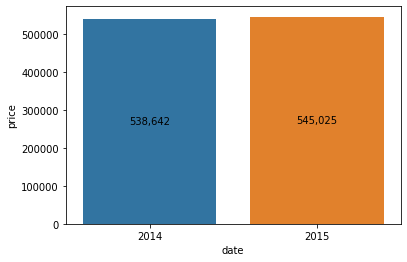

In [9]:
grouped = train['price'].groupby(train['date'].dt.year).mean()

ax = sns.barplot(data=grouped.reset_index(), x='date', y='price')
containers = ax.containers[0]
ax.bar_label(containers, labels=[f'{x:,.0f}' for x in containers.datavalues], label_type='center')
plt.show()

년도별 평균 가격입니다. 별 차이 없으므로 컬럼에서 제외해도 될 것 같습니다.

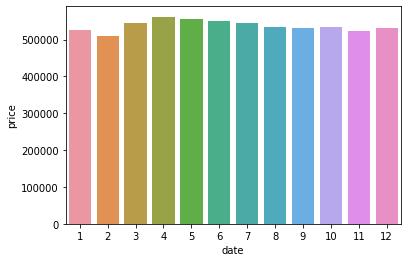

In [10]:
grouped = train['price'].groupby(train['date'].dt.month).mean()

ax = sns.barplot(data=grouped.reset_index(), x='date', y='price')
plt.show()

월별 평균 가격입니다. 이번에도 별 차이 없습니다.

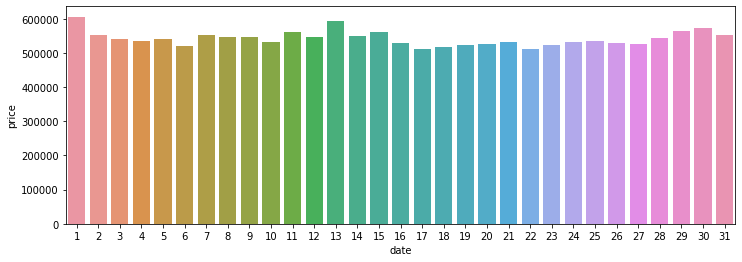

In [11]:
grouped = train['price'].groupby(train['date'].dt.day).mean()

plt.figure(figsize=(12, 4))
ax = sns.barplot(data=grouped.reset_index(), x='date', y='price')
plt.show()

일별 평균 가격입니다. 마찬가지로 별 차이 없습니다.  

`date` 컬럼은 제외해도 될 것 같습니다.  

**1. 가격과 관계없는 `id` 컬럼은 제거하기**  
**2. 가격과 관계없는 `date` 컬럼도 제거하기**

bedrooms
0        4
1      133
2     1931
3     6835
4     4797
5     1108
6      188
7       22
8       10
9        5
10       2
Name: price, dtype: int64


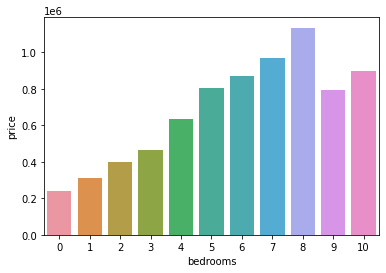

In [12]:
grouped = train['price'].groupby(train['bedrooms'])
print(grouped.count())

ax = sns.barplot(data=grouped.mean().reset_index(), x='bedrooms', y='price')
plt.show()

침실 수별 평균 가격입니다. 침실 수에 비례하는 평균 가격을 가지고 있습니다.  
학습에 적극적으로 활용해야 할 것 같습니다.

bathrooms
0.00       4
0.50       3
0.75      45
1.00    2675
1.25       5
1.50    1009
1.75    2112
2.00    1357
2.25    1433
2.50    3748
2.75     843
3.00     493
3.25     410
3.50     510
3.75     108
4.00     100
4.25      57
4.50      64
4.75      16
5.00      14
5.25      11
5.50       7
5.75       3
6.00       2
6.25       1
6.75       1
7.50       1
7.75       1
8.00       2
Name: price, dtype: int64


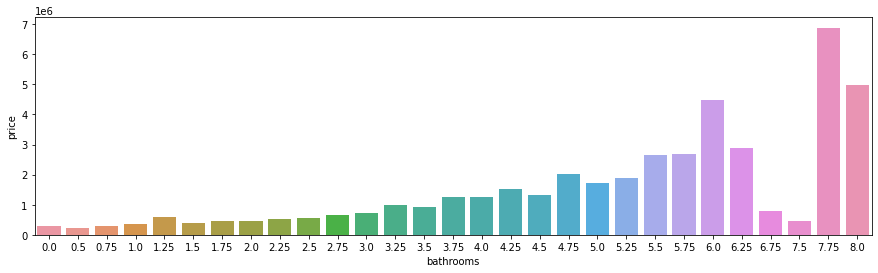

In [13]:
grouped = train['price'].groupby(train['bathrooms'])
print(grouped.count())

plt.figure(figsize=(15, 4))
ax = sns.barplot(data=grouped.mean().reset_index(), x='bathrooms', y='price')
plt.show()

화장실 수별 평균 가격입니다. 오르는 듯 싶다가 6.75개와 7.5개에서 값이 많이 떨어졌습니다.  
데이터 수가 적기 때문에 발생한 현상인 듯 보이므로 각 값들에 소수점 내림을 하면  
6.75개는 6개로, 7.5개는 7.75개의 가격과 합쳐지면서 해결될 것 같습니다.  

**1. 가격과 관계없는 `id` 컬럼은 제거하기**  
**2. 가격과 관계없는 `date` 컬럼도 제거하기**  
**3. 화장실 수 컬럼의 값들 소수점 내림하기 (`np.trunc`)**

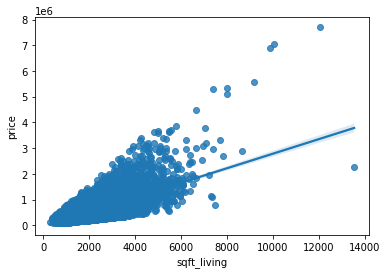

In [14]:
sns.regplot(x=train['sqft_living'], y=y)
plt.show()

주거 공간의 면적과 가격의 관계를 나타내는 선을 그었습니다.  
Regression 결과를 확인하기 위한 용도의 그래프이긴 한데, 특성과 타깃의 관계를 확인하기 위해 사용했습니다.  
점이 워낙 많아서 크게 와닿지 않을 수 있지만 그래도 서로 관계가 있는 모습을 보이고 있습니다.

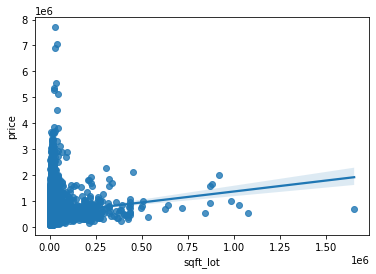

In [15]:
sns.regplot(x=train['sqft_lot'], y=y)
plt.show()

이번에는 땅의 면적과 가격의 관계입니다. 그래프가 많이 애매합니다.  
땅의 면적은 다르게 해석하면 마당과 같은 공간을 포함한 넓이가 됩니다.  
땅의 면적에서 주거 면적을 뺀 값으로 가격과의 관계를 확인해보겠습니다.

In [16]:
temp = train.copy()
temp['sqft_yard'] = temp['sqft_lot'] - temp['sqft_living']

temp

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_yard
0,0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,4470
1,1,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,9230
2,2,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,6400
3,3,2014-06-27,257500.0,3,2.25,1715,6819,2.0,0,0,...,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,5104
4,4,2015-01-15,291850.0,3,1.50,1060,9711,1.0,0,0,...,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,8651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,2014-10-14,610685.0,4,2.50,2520,6023,2.0,0,0,...,2520,0,2014,0,98056,47.5137,-122.167,2520,6023,3503
15031,15031,2015-03-26,1007500.0,4,3.50,3510,7200,2.0,0,0,...,2600,910,2009,0,98136,47.5537,-122.398,2050,6200,3690
15032,15032,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0,...,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,-399
15033,15033,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0,...,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,3503


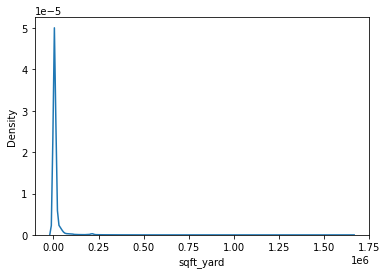

In [17]:
sns.kdeplot(temp['sqft_yard'])
plt.show()

분포가 상당히 모여있습니다. 로그변환을 해보겠습니다.

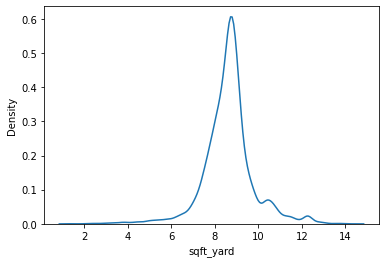

In [18]:
temp = np.log1p(temp['sqft_yard'])

sns.kdeplot(temp)
plt.show()

이제 다시 관계를 확인해보겠습니다.

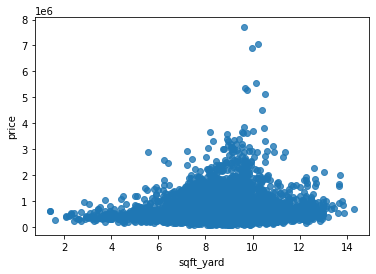

In [19]:
sns.regplot(x=temp, y=y)
plt.show()

일단 사용해도록 하겠습니다.  

**1. 가격과 관계없는 `id` 컬럼은 제거하기**  
**2. 가격과 관계없는 `date` 컬럼도 제거하기**  
**3. `bathrooms` 컬럼의 값들 소수점 내림하기 (`np.trunc`)**  
**4. `sqft_lot`에서 `sqft_living`을 뺸 새로운 컬럼 생성하고 로그변환하기**  

floors
1.0    7361
1.5    1330
2.0    5810
2.5     113
3.0     417
3.5       4
Name: price, dtype: int64


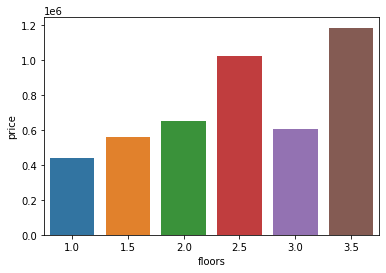

In [20]:
grouped = train['price'].groupby(train['floors'])
print(grouped.count())

ax = sns.barplot(data=grouped.mean().reset_index(), x='floors', y='price')
plt.show()

층 수별 평균 가격입니다.  층 수에 비례해서 가격이 올라가다가 2.5층이 비교적 높고, 3층이 비교적 낮은 모습을 보이고 있습니다.  
다른 정보도 확인을 해봐야겠습니다.

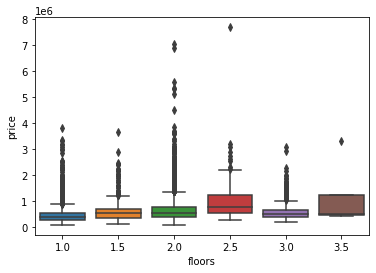

In [21]:
ax = sns.boxplot(data=train, x='floors', y='price')
plt.show()

2층과 2.5층에 이상치가 많이 있습니다. 이상치를 제거해주겠습니다.  

**1. 가격과 관계없는 `id` 컬럼은 제거하기**  
**2. 가격과 관계없는 `date` 컬럼도 제거하기**  
**3. `bathrooms` 컬럼의 값들 소수점 내림하기 (`np.trunc`)**  
**4. `sqft_lot`에서 `sqft_living`을 뺸 새로운 컬럼 생성하고 로그변환하기**  
**5. `floors` 컬럼의 이상치 제거하기**  

waterfront
0    14928
1      107
Name: price, dtype: int64


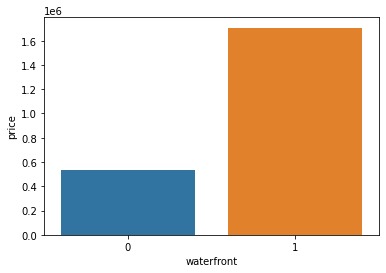

In [22]:
grouped = train['price'].groupby(train['waterfront'])
print(grouped.count())

ax = sns.barplot(data=grouped.mean().reset_index(), x='waterfront', y='price')
plt.show()

리버뷰 유무의 평균 가격입니다. 값 `0`은 주변에 강이 없다는 뜻이고, `1`은 강이 있다는 뜻입니다.  
강이 있으면 가격을 비싸게 학습해도 될 것 같습니다.

grade
1        1
3        2
4       23
5      174
6     1406
7     6228
8     4207
9     1855
10     781
11     288
12      61
13       9
Name: price, dtype: int64


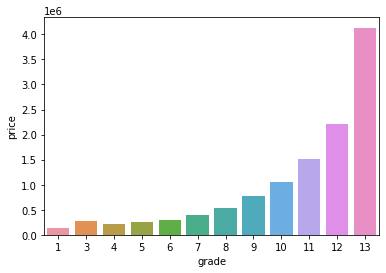

In [23]:
grouped = train['price'].groupby(train['grade'])
print(grouped.count())

ax = sns.barplot(data=grouped.mean().reset_index(), x='grade', y='price')
plt.show()

King County grading 시스템 기준으로 매긴 집의 등급 별 평균 가격입니다.  
잘 모르는 시스템이지만 적극 반영해도 좋을 것 같습니다.

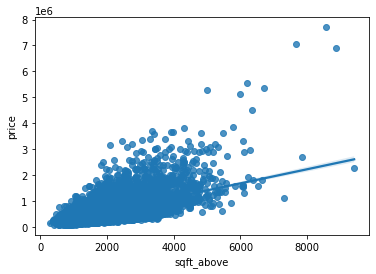

In [24]:
sns.regplot(x=train['sqft_above'], y=y)
plt.show()

지하실을 제외한 면적과 가격의 관계를 나타내는 그래프입니다.  
가격과 관계는 있어보이나 지하실을 제외한 면적이라면 지하실이 없는 집은 주거 면적이 곧 해당 컬럼이고,  
지하실 면적과 지하실을 제외한 면적을 합한 값이 곧 주거 면적이란 뜻입니다.  
데이터마다 지하실 면적 값을 가지고 있는지 확인하고 지하실 유무로 바꿔준 후 지하실 유무에 따른 관계를 살펴봐도 좋을 것 같습니다.

sqft_basement
0    9143
1    5892
Name: price, dtype: int64


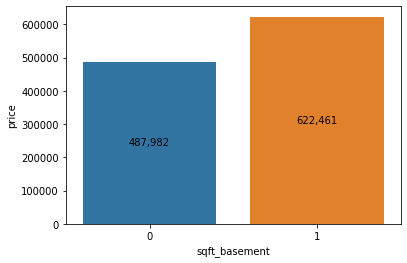

In [25]:
temp = train.copy()
temp['sqft_basement'] = train['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)

grouped = temp['price'].groupby(temp['sqft_basement'])
print(grouped.count())

ax = sns.barplot(data=grouped.mean().reset_index(), x='sqft_basement', y='price')
containers = ax.containers[0]
ax.bar_label(containers, labels=[f'{x:,.0f}' for x in containers.datavalues], label_type='center')
plt.show()

차이가 생기는 모습을 볼 수 있습니다.  
지하실 면적과 지하실 외 면적은 제거하고 지하실 유무로 새로운 컬럼을 생성해주겠습니다.  

**1. 가격과 관계없는 `id` 컬럼은 제거하기**  
**2. 가격과 관계없는 `date` 컬럼도 제거하기**  
**3. `bathrooms` 컬럼의 값들 소수점 내림하기 (`np.trunc`)**  
**4. `sqft_lot`에서 `sqft_living`을 뺸 새로운 컬럼 생성하고 로그변환하기**  
**5. `floors` 컬럼의 이상치 제거하기**  
**6. `sqft_basement` 값을 이용해 지하실 유무를 판단하는 `1` 또는 `0`의 값으로 변경하고 지하실 면적 컬럼 제거하기**

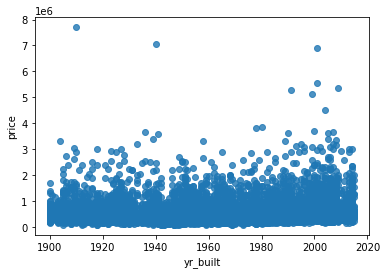

In [26]:
sns.regplot(x=train['yr_built'], y=y)
plt.show()

지어진 연도와 가격과의 관계를 나타낸 그래프입니다. 관계가 없는 듯 보입니다.  

**1. 가격과 관계없는 `id` 컬럼은 제거하기**  
**2. 가격과 관계없는 `date` 컬럼도 제거하기**  
**3. `bathrooms` 컬럼의 값들 소수점 내림하기 (`np.trunc`)**  
**4. `sqft_lot`에서 `sqft_living`을 뺸 새로운 컬럼 생성하고 로그변환하기**  
**5. `floors` 컬럼의 이상치 제거하기**  
**6. `sqft_basement` 값을 이용해 지하실 유무를 판단하고 `1` 또는 `0`의 값으로 변경하고 지하실 면적 컬럼 제거하기**  
**7. 가격과 관계없는 `yr_built` 컬럼 제거하기**  

In [27]:
print(train['yr_renovated'].describe())

count    15035.000000
mean        83.798936
std        400.398498
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2015.000000
Name: yr_renovated, dtype: float64


집을 재건축한 년도의 분포 수치 통계입니다.  
재건축한 이력이 없으면 0의 값을 가지는데 그 데이터가 역시 너무 많습니다.  
값이 0인지 아닌지를 따져서 재건축한 이력이 있는 집과 그렇지 않은 집의 가격을 비교해보겠습니다.

yr_renovated
0    14404
1      631
Name: price, dtype: int64


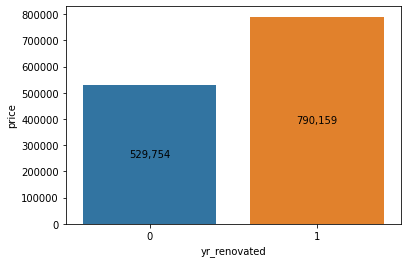

In [28]:
temp = train.copy()
temp['yr_renovated'] = train['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)

grouped = temp['price'].groupby(temp['yr_renovated'])
print(grouped.count())

ax = sns.barplot(data=grouped.mean().reset_index(), x='yr_renovated', y='price')
containers = ax.containers[0]
ax.bar_label(containers, labels=[f'{x:,.0f}' for x in containers.datavalues], label_type='center')
plt.show()

재건축한 이력 여부에 대한 평균 가격입니다.  
가격의 차이가 생기기는 하지만 재건축한 적이 없는 집이 14404개, 재건축한 이력이 있는 집이 631개로  
분포가 몰려있기 때문에 가격 차이가 발생한건지 아직 모릅니다.

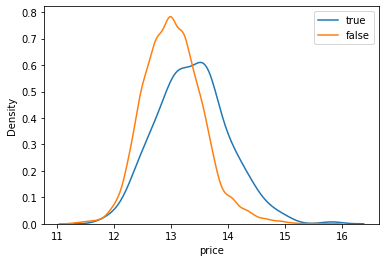

In [29]:
yr_renovated = np.log1p(train['price'].loc[train['yr_renovated']>0])
non_renovated = np.log1p(train['price'].loc[train['yr_renovated']==0])

sns.kdeplot(yr_renovated, label='true')
sns.kdeplot(non_renovated, label='false')
plt.legend()
plt.show()

재건축한 이력이 있는 집과 없는 집의 분포 그래프입니다.  
분산은 오히려 재건축한 이력이 있는 집이 더 낮은 것으로,  
재건축한 이력이 있는 집의 평균 가격이 높은 것은 이상치나 분포에 의한 결과가 아님을 나타냅니다.  

**1. 가격과 관계없는 `id` 컬럼은 제거하기**  
**2. 가격과 관계없는 `date` 컬럼도 제거하기**  
**3. `bathrooms` 컬럼의 값들 소수점 내림하기 (`np.trunc`)**  
**4. `sqft_lot`에서 `sqft_living`을 뺸 새로운 컬럼 생성하고 로그변환하기**  
**5. `floors` 컬럼의 이상치 제거하기**  
**6. `sqft_basement` 값을 이용해 지하실 유무를 판단하고 `1` 또는 `0`의 값으로 변경하고 지하실 면적 컬럼 제거하기**  
**7. 가격과 관계없는 `yr_built` 컬럼 제거하기**  
**8. `yr_renovated` 값을 이용해 재건축 이력을 판단하고 `1` 또는 `0`의 값으로 변경하기**  

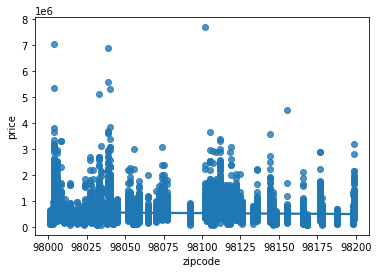

In [30]:
sns.regplot(x=train['zipcode'], y=y)
plt.show()

우편번호와 가격의 관계를 나타내는 그래프입니다.  
아무런 관계도 없는 것으로 확인됐습니다.  

**1. 가격과 관계없는 `id` 컬럼은 제거하기**  
**2. 가격과 관계없는 `date` 컬럼도 제거하기**  
**3. `bathrooms` 컬럼의 값들 소수점 내림하기 (`np.trunc`)**  
**4. `sqft_lot`에서 `sqft_living`을 뺸 새로운 컬럼 생성하고 로그변환하기**  
**5. `floors` 컬럼의 이상치 제거하기**  
**6. `sqft_basement` 값을 이용해 지하실 유무를 판단하고 `1` 또는 `0`의 값으로 변경하고 지하실 면적 컬럼 제거하기**  
**7. 가격과 관계없는 `yr_built` 컬럼 제거하기**  
**8. `yr_renovated` 값을 이용해 재건축 이력을 판단하고 `1` 또는 `0`의 값으로 변경하기**  
**9. 가격과 관계없는 `zipcode` 컬럼 제거하기**  

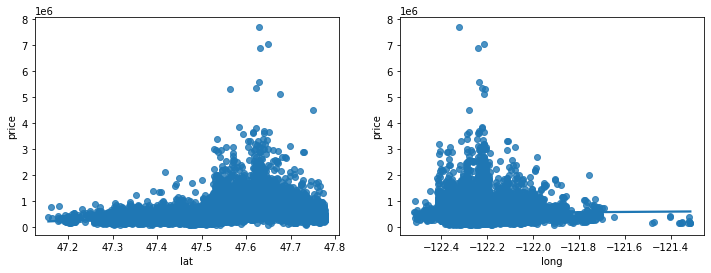

In [31]:
plt.figure(figsize=[12, 4])
plt.subplot(121)
sns.regplot(x=train['lat'], y=y)
plt.subplot(122)
sns.regplot(x=train['long'], y=y)
plt.show()

경도와 위도의 가격 관계 그래프입니다.  
경도가 낮고 위도가 높으면 시골이란 것을 확인할 수 있을 것 같습니다.  
경도와 위도를 함께 계산해 도시인지 시골인지를 구분해주는 새로운 컬럼을 생성해주겠습니다.  

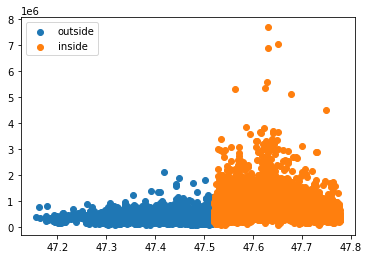

In [32]:
inside_lat = train.loc[train['lat'] >= 47.52]
outside_lat = train.loc[train['lat'] < 47.52]

plt.scatter(x=outside_lat['lat'], y=outside_lat['price'], label="outside")
plt.scatter(x=inside_lat['lat'], y=inside_lat['price'], label="inside")
plt.legend()

plt.show()

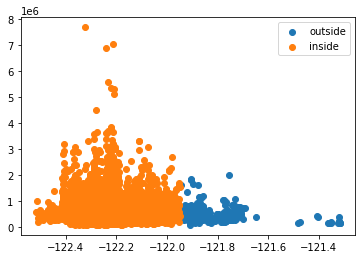

In [33]:
inside_long = train.loc[train['long'] <= -121.95]
outside_long = train.loc[train['long'] > -121.95]

plt.scatter(x=outside_long['long'], y=outside_long['price'], label="outside")
plt.scatter(x=inside_long['long'], y=inside_long['price'], label="inside")
plt.legend()

plt.show()

**1. 가격과 관계없는 `id` 컬럼은 제거하기**  
**2. 가격과 관계없는 `date` 컬럼도 제거하기**  
**3. `bathrooms` 컬럼의 값들 소수점 내림하기 (`np.trunc`)**  
**4. `sqft_lot`에서 `sqft_living`을 뺸 새로운 컬럼 생성하고 로그변환하기**  
**5. `floors` 컬럼의 이상치 제거하기**  
**6. `sqft_basement` 값을 이용해 지하실 유무를 판단하고 `1` 또는 `0`의 값으로 변경하고 지하실 면적 컬럼 제거하기**  
**7. 가격과 관계없는 `yr_built` 컬럼 제거하기**  
**8. `yr_renovated` 값을 이용해 재건축 이력을 판단하고 `1` 또는 `0`의 값으로 변경하기**  
**9. 가격과 관계없는 `zipcode` 컬럼 제거하기**  
**10. 경도와 위도(`lat`, `long`)를 이용해 도시와 시골 컬럼 생성하기(경도 47.52 이상, 위도 -121.95 이하)**  

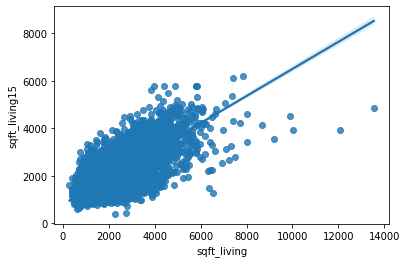

In [34]:
sns.regplot(x=train['sqft_living'], y=train['sqft_living15'])
plt.show()

2015년 기준 주거 면적과 판매 당시 주거 면적의 관계를 나타낸 그래프입니다.  
예상했던 대로 서로 거의 비슷한 값을 가지고 있습니다.  
그대로 쓰면 주거 면적 컬럼과 중복되니 2015년과 판매 당시의 차이를 계산한 변수를 생성해서 가격과의 관계를 확인해보겠습니다.

In [35]:
temp = train.copy()
temp['chliving'] = temp['sqft_living'] - temp['sqft_living15']

temp['chliving'].describe()

count    15035.000000
mean        91.035451
std        599.101462
min      -2310.000000
25%       -220.000000
50%          0.000000
75%        310.000000
max       8690.000000
Name: chliving, dtype: float64

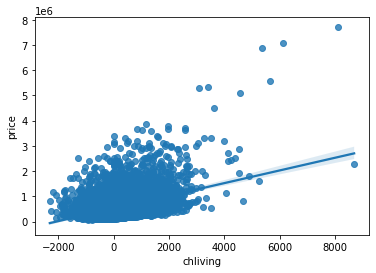

In [36]:
sns.regplot(x=temp['chliving'], y=y)
plt.show()

판매 당시 주거 면적에서 2015년 주거 면적을 뺀 값과 가격과의 관계 그래프입니다.  
관계가 있는 것 같으니 활용하겠습니다.  

**1. 가격과 관계없는 `id` 컬럼은 제거하기**  
**2. 가격과 관계없는 `date` 컬럼도 제거하기**  
**3. `bathrooms` 컬럼의 값들 소수점 내림하기 (`np.trunc`)**  
**4. `sqft_lot`에서 `sqft_living`을 뺸 새로운 컬럼 생성하고 로그변환하기**  
**5. `floors` 컬럼의 이상치 제거하기**  
**6. `sqft_basement` 값을 이용해 지하실 유무를 판단하고 `1` 또는 `0`의 값으로 변경하고 지하실 면적 컬럼 제거하기**  
**7. 가격과 관계없는 `yr_built` 컬럼 제거하기**  
**8. `yr_renovated` 값을 이용해 재건축 이력을 판단하고 `1` 또는 `0`의 값으로 변경하기**  
**9. 가격과 관계없는 `zipcode` 컬럼 제거하기**  
**10. 경도와 위도(`lat`, `long`)를 이용해 도시와 시골 컬럼 생성하기(경도 47.52 이상, 위도 -121.95 이하)**  
**11. `sqft_living` 에서 `sqft_living15`를 뺀 값을 새로운 컬럼에 저장하고 `sqft_living15` 컬럼 제거하기**  

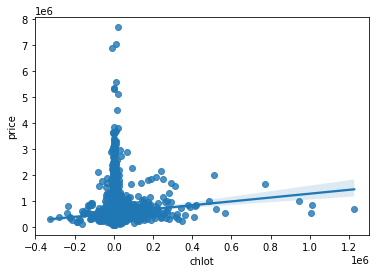

In [37]:
temp = train.copy()
temp['chlot'] = temp['sqft_lot'] - temp['sqft_lot15']

sns.regplot(x=temp['chlot'], y=y)
plt.show()

2015년 기준 땅의 면적도 같은 방법으로 가격과의 관계를 확인해봤지만  
판매 당시 땅의 면적도 관계가 없던 바가 있어 2015년 기준 땅의 면적도 활용하기엔 좋지 않아보입니다.  

**1. 가격과 관계없는 `id` 컬럼은 제거하기**  
**2. 가격과 관계없는 `date` 컬럼도 제거하기**  
**3. `bathrooms` 컬럼의 값들 소수점 내림하기 (`np.trunc`)**  
**4. `sqft_lot`에서 `sqft_living`을 뺸 새로운 컬럼 생성하고 로그변환하기**  
**5. `floors` 컬럼의 이상치 제거하기**  
**6. `sqft_basement` 값을 이용해 지하실 유무를 판단하고 `1` 또는 `0`의 값으로 변경하고 지하실 면적 컬럼 제거하기**  
**7. 가격과 관계없는 `yr_built` 컬럼 제거하기**  
**8. `yr_renovated` 값을 이용해 재건축 이력을 판단하고 `1` 또는 `0`의 값으로 변경하기**  
**9. 가격과 관계없는 `zipcode` 컬럼 제거하기**  
**10. 경도와 위도(`lat`, `long`)를 이용해 도시와 시골 컬럼 생성하기(경도 47.52 이상, 위도 -121.95 이하)**  
**11. `sqft_living` 에서 `sqft_living15`를 뺀 값을 새로운 컬럼에 저장하고 `sqft_living15` 컬럼 제거하기**  
**12 가격과 관계없는 `sqft_lot15` 컬럼 제거하기**

- - -
### 데이터 전처리

데이터를 분석하면서 총 12가지의 전처리 방법을 생각해냈습니다.  
차례대로 실행한 후 마지막엔 과학습을 할만한 값을 가진 컬럼이 있는지 확인 후 정규화를 진행하겠습니다.

In [38]:
train_len = len(train)

data = pd.concat((train, test), axis=0)
data = data.reset_index(drop=True)

data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,2014-06-27,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,2015-01-15,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,21498,2014-06-26,NaN,3,1.75,1500,11968,1.0,0,0,...,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
21499,21499,2015-01-26,NaN,3,2.00,1490,1126,3.0,0,0,...,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
21500,21500,2015-02-19,NaN,3,2.50,1310,1294,2.0,0,0,...,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
21501,21501,2014-06-23,NaN,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


먼저 `train`과 `test`를 **`concat`**으로 결합한 새로운 `data` 데이터프레임을 만들어줍니다.  
학습 전에 결합한 부분을 기억했다가 되돌릴 수 있도록 `train_len`에 `train` 데이터의 끝을 표시해줄 수 있는 값을 넣어줍니다.

In [39]:
data.drop(columns=['id', 'date', 'yr_built', 'zipcode', 'sqft_lot15'], inplace=True)

data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_renovated,lat,long,sqft_living15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,0,47.5112,-122.257,1340
1,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,0,47.7379,-122.233,2720
2,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,0,47.6168,-122.045,1800
3,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,0,47.3097,-122.327,2238
4,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,0,47.4095,-122.315,1650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,NaN,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,0,47.3095,-122.002,1320
21499,NaN,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,0,47.5699,-122.288,1400
21500,NaN,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,0,47.5773,-122.409,1330
21501,NaN,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,0,47.5944,-122.299,1020


가격과 관계없는 컬럼 제거 후 16개의 컬럼이 남았습니다.

~~**1. 가격과 관계없는 `id` 컬럼은 제거하기**~~  
~~**2. 가격과 관계없는 `date` 컬럼도 제거하기**~~  
**3. `bathrooms` 컬럼의 값들 소수점 내림하기 (`np.trunc`)**  
**4. `sqft_lot`에서 `sqft_living`을 뺸 새로운 컬럼 생성하고 로그변환하기**  
**5. `floors` 컬럼의 이상치 제거하기**  
**6. `sqft_basement` 값을 이용해 지하실 유무를 판단하고 `1` 또는 `0`의 값으로 변경하고 지하실 면적 컬럼 제거하기**  
~~**7. 가격과 관계없는 `yr_built` 컬럼 제거하기**~~  
**8. `yr_renovated` 값을 이용해 재건축 이력을 판단하고 `1` 또는 `0`의 값으로 변경하기**  
~~**9. 가격과 관계없는 `zipcode` 컬럼 제거하기**~~  
**10. 경도와 위도(`lat`, `long`)를 이용해 도시와 시골 컬럼 생성하기(경도 47.52 이상, 위도 -121.95 이하)**  
**11. `sqft_living` 에서 `sqft_living15`를 뺀 값을 새로운 컬럼에 저장하고 `sqft_living15` 컬럼 제거하기**  
~~**12 가격과 관계없는 `sqft_lot15` 컬럼 제거하기**~~  

벌써 7가지 남았습니다.

In [40]:
data['bathrooms'] = np.trunc(data['bathrooms'])

data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_renovated,lat,long,sqft_living15
0,221900.0,3,1.0,1180,5650,1.0,0,0,3,7,1180,0,0,47.5112,-122.257,1340
1,180000.0,2,1.0,770,10000,1.0,0,0,3,6,770,0,0,47.7379,-122.233,2720
2,510000.0,3,2.0,1680,8080,1.0,0,0,3,8,1680,0,0,47.6168,-122.045,1800
3,257500.0,3,2.0,1715,6819,2.0,0,0,3,7,1715,0,0,47.3097,-122.327,2238
4,291850.0,3,1.0,1060,9711,1.0,0,0,3,7,1060,0,0,47.4095,-122.315,1650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,NaN,3,1.0,1500,11968,1.0,0,0,3,6,1500,0,0,47.3095,-122.002,1320
21499,NaN,3,2.0,1490,1126,3.0,0,0,3,8,1490,0,0,47.5699,-122.288,1400
21500,NaN,3,2.0,1310,1294,2.0,0,0,3,8,1180,130,0,47.5773,-122.409,1330
21501,NaN,2,0.0,1020,1350,2.0,0,0,3,7,1020,0,0,47.5944,-122.299,1020


`numpy`의 `np.turnc` 메서드로 `bathrooms` 컬럼의 값을 소수점 내림 했습니다.

~~**1. 가격과 관계없는 `id` 컬럼은 제거하기**~~  
~~**2. 가격과 관계없는 `date` 컬럼도 제거하기**~~  
~~**3. `bathrooms` 컬럼의 값들 소수점 내림하기 (`np.trunc`)**~~  
**4. `sqft_lot`에서 `sqft_living`을 뺸 새로운 컬럼 생성하고 로그변환하기**  
**5. `floors` 컬럼의 이상치 제거하기**  
**6. `sqft_basement` 값을 이용해 지하실 유무를 판단하고 `1` 또는 `0`의 값으로 변경하고 지하실 면적 컬럼 제거하기**  
~~**7. 가격과 관계없는 `yr_built` 컬럼 제거하기**~~  
**8. `yr_renovated` 값을 이용해 재건축 이력을 판단하고 `1` 또는 `0`의 값으로 변경하기**  
~~**9. 가격과 관계없는 `zipcode` 컬럼 제거하기**~~  
**10. 경도와 위도(`lat`, `long`)를 이용해 도시와 시골 컬럼 생성하기(경도 47.52 이상, 위도 -121.95 이하)**  
**11. `sqft_living` 에서 `sqft_living15`를 뺀 값을 새로운 컬럼에 저장하고 `sqft_living15` 컬럼 제거하기**  
~~**12 가격과 관계없는 `sqft_lot15` 컬럼 제거하기**~~  

In [41]:
data['sqft_lot'] = data['sqft_lot'] - data['sqft_living']

data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_renovated,lat,long,sqft_living15
0,221900.0,3,1.0,1180,4470,1.0,0,0,3,7,1180,0,0,47.5112,-122.257,1340
1,180000.0,2,1.0,770,9230,1.0,0,0,3,6,770,0,0,47.7379,-122.233,2720
2,510000.0,3,2.0,1680,6400,1.0,0,0,3,8,1680,0,0,47.6168,-122.045,1800
3,257500.0,3,2.0,1715,5104,2.0,0,0,3,7,1715,0,0,47.3097,-122.327,2238
4,291850.0,3,1.0,1060,8651,1.0,0,0,3,7,1060,0,0,47.4095,-122.315,1650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,NaN,3,1.0,1500,10468,1.0,0,0,3,6,1500,0,0,47.3095,-122.002,1320
21499,NaN,3,2.0,1490,-364,3.0,0,0,3,8,1490,0,0,47.5699,-122.288,1400
21500,NaN,3,2.0,1310,-16,2.0,0,0,3,8,1180,130,0,47.5773,-122.409,1330
21501,NaN,2,0.0,1020,330,2.0,0,0,3,7,1020,0,0,47.5944,-122.299,1020


`sqft_lot` 컬럼을 땅의 면적에서 주거 면적을 뺀 값으로 변경하고 로그변환을 실행했습니다.

~~**1. 가격과 관계없는 `id` 컬럼은 제거하기**~~  
~~**2. 가격과 관계없는 `date` 컬럼도 제거하기**~~  
~~**3. `bathrooms` 컬럼의 값들 소수점 내림하기 (`np.trunc`)**~~  
~~**4. `sqft_lot`에서 `sqft_living`을 뺸 새로운 컬럼 생성하고 로그변환하기**~~  
**5. `floors` 컬럼의 이상치 제거하기**  
**6. `sqft_basement` 값을 이용해 지하실 유무를 판단하고 `1` 또는 `0`의 값으로 변경하고 지하실 면적 컬럼 제거하기**  
~~**7. 가격과 관계없는 `yr_built` 컬럼 제거하기**~~  
**8. `yr_renovated` 값을 이용해 재건축 이력을 판단하고 `1` 또는 `0`의 값으로 변경하기**  
~~**9. 가격과 관계없는 `zipcode` 컬럼 제거하기**~~  
**10. 경도와 위도(`lat`, `long`)를 이용해 도시와 시골 컬럼 생성하기(경도 47.52 이상, 위도 -121.95 이하)**  
**11. `sqft_living` 에서 `sqft_living15`를 뺀 값을 새로운 컬럼에 저장하고 `sqft_living15` 컬럼 제거하기**  
~~**12 가격과 관계없는 `sqft_lot15` 컬럼 제거하기**~~  

In [42]:
temp = train.loc[train['floors']==2.5]
temp = temp.sort_values(by='price', ascending=False)

temp.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5108,5108,2014-10-13,7700000.0,6,8.00,12050,27600,2.5,0,3,...,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
5560,5560,2014-09-23,3200000.0,6,5.00,7100,18200,2.5,0,0,...,13,5240,1860,1933,2002,98199,47.6427,-122.408,3130,6477
10648,10648,2015-02-12,3065000.0,5,3.00,4150,7500,2.5,0,4,...,11,3510,640,1909,0,98119,47.6303,-122.362,2250,4050
9772,9772,2014-09-26,2885000.0,7,3.00,5350,14400,2.5,0,0,...,10,5020,330,1910,0,98112,47.6295,-122.285,3050,7469
4215,4215,2014-12-03,2725000.0,4,4.25,6410,43838,2.5,0,2,...,12,5610,800,1906,0,98144,47.5703,-122.280,2270,6630


`floors` 2.5층을 가진 이상치가 가장 큰 5108번 데이터를 제거해주겠습니다.

In [43]:
data.drop(data.index[5108], inplace=True)
y.drop(y.index[5108], inplace=True)
train_len -= 1

print(data.shape)

(21502, 16)


타깃 데이터도 잊지 않고 제거해줍니다.

~~**1. 가격과 관계없는 `id` 컬럼은 제거하기**~~  
~~**2. 가격과 관계없는 `date` 컬럼도 제거하기**~~  
~~**3. `bathrooms` 컬럼의 값들 소수점 내림하기 (`np.trunc`)**~~  
~~**4. `sqft_lot`에서 `sqft_living`을 뺸 새로운 컬럼 생성하고 로그변환하기**~~  
~~**5. `floors` 컬럼의 이상치 제거하기**~~  
**6. `sqft_basement` 값을 이용해 지하실 유무를 판단하고 `1` 또는 `0`의 값으로 변경하고 지하실 면적 컬럼 제거하기**  
~~**7. 가격과 관계없는 `yr_built` 컬럼 제거하기**~~  
**8. `yr_renovated` 값을 이용해 재건축 이력을 판단하고 `1` 또는 `0`의 값으로 변경하기**  
~~**9. 가격과 관계없는 `zipcode` 컬럼 제거하기**~~  
**10. 경도와 위도(`lat`, `long`)를 이용해 도시와 시골 컬럼 생성하기(경도 47.52 이상, 위도 -121.95 이하)**  
**11. `sqft_living` 에서 `sqft_living15`를 뺀 값을 새로운 컬럼에 저장하고 `sqft_living15` 컬럼 제거하기**  
~~**12 가격과 관계없는 `sqft_lot15` 컬럼 제거하기**~~  

In [44]:
data['sqft_basement'] = data['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)
del data['sqft_above']

data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_renovated,lat,long,sqft_living15
0,221900.0,3,1.0,1180,4470,1.0,0,0,3,7,0,0,47.5112,-122.257,1340
1,180000.0,2,1.0,770,9230,1.0,0,0,3,6,0,0,47.7379,-122.233,2720
2,510000.0,3,2.0,1680,6400,1.0,0,0,3,8,0,0,47.6168,-122.045,1800
3,257500.0,3,2.0,1715,5104,2.0,0,0,3,7,0,0,47.3097,-122.327,2238
4,291850.0,3,1.0,1060,8651,1.0,0,0,3,7,0,0,47.4095,-122.315,1650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,NaN,3,1.0,1500,10468,1.0,0,0,3,6,0,0,47.3095,-122.002,1320
21499,NaN,3,2.0,1490,-364,3.0,0,0,3,8,0,0,47.5699,-122.288,1400
21500,NaN,3,2.0,1310,-16,2.0,0,0,3,8,1,0,47.5773,-122.409,1330
21501,NaN,2,0.0,1020,330,2.0,0,0,3,7,0,0,47.5944,-122.299,1020


지하실 외 면적 컬럼은 제거하고 지하실 면적 컬럼이 0인지 아닌지를 계산해서  
지하실의 유무를 `0`과 `1`로 표현하는 컬럼으로 변경했습니다.  

~~**1. 가격과 관계없는 `id` 컬럼은 제거하기**~~  
~~**2. 가격과 관계없는 `date` 컬럼도 제거하기**~~  
~~**3. `bathrooms` 컬럼의 값들 소수점 내림하기 (`np.trunc`)**~~  
~~**4. `sqft_lot`에서 `sqft_living`을 뺸 새로운 컬럼 생성하고 로그변환하기**~~  
~~**5. `floors` 컬럼의 이상치 제거하기**~~  
~~**6. `sqft_basement` 값을 이용해 지하실 유무를 판단하고 `1` 또는 `0`의 값으로 변경하고 지하실 면적 컬럼 제거하기**~~  
~~**7. 가격과 관계없는 `yr_built` 컬럼 제거하기**~~  
**8. `yr_renovated` 값을 이용해 재건축 이력을 판단하고 `1` 또는 `0`의 값으로 변경하기**  
~~**9. 가격과 관계없는 `zipcode` 컬럼 제거하기**~~  
**10. 경도와 위도(`lat`, `long`)를 이용해 도시와 시골 컬럼 생성하기(경도 47.52 이상, 위도 -121.95 이하)**  
**11. `sqft_living` 에서 `sqft_living15`를 뺀 값을 새로운 컬럼에 저장하고 `sqft_living15` 컬럼 제거하기**  
~~**12 가격과 관계없는 `sqft_lot15` 컬럼 제거하기**~~  

In [45]:
data['yr_renovated'] = data['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)

data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_renovated,lat,long,sqft_living15
0,221900.0,3,1.0,1180,4470,1.0,0,0,3,7,0,0,47.5112,-122.257,1340
1,180000.0,2,1.0,770,9230,1.0,0,0,3,6,0,0,47.7379,-122.233,2720
2,510000.0,3,2.0,1680,6400,1.0,0,0,3,8,0,0,47.6168,-122.045,1800
3,257500.0,3,2.0,1715,5104,2.0,0,0,3,7,0,0,47.3097,-122.327,2238
4,291850.0,3,1.0,1060,8651,1.0,0,0,3,7,0,0,47.4095,-122.315,1650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,NaN,3,1.0,1500,10468,1.0,0,0,3,6,0,0,47.3095,-122.002,1320
21499,NaN,3,2.0,1490,-364,3.0,0,0,3,8,0,0,47.5699,-122.288,1400
21500,NaN,3,2.0,1310,-16,2.0,0,0,3,8,1,0,47.5773,-122.409,1330
21501,NaN,2,0.0,1020,330,2.0,0,0,3,7,0,0,47.5944,-122.299,1020


`yr_renovated` 컬럼도 값이 0인지 아닌지를 판단해서 재건축 이력이 있는지 없는지를 `0`과 `1`로 표현하는 컬럼으로 변경했습니다.  

~~**1. 가격과 관계없는 `id` 컬럼은 제거하기**~~  
~~**2. 가격과 관계없는 `date` 컬럼도 제거하기**~~  
~~**3. `bathrooms` 컬럼의 값들 소수점 내림하기 (`np.trunc`)**~~  
~~**4. `sqft_lot`에서 `sqft_living`을 뺸 새로운 컬럼 생성하고 로그변환하기**~~  
~~**5. `floors` 컬럼의 이상치 제거하기**~~  
~~**6. `sqft_basement` 값을 이용해 지하실 유무를 판단하고 `1` 또는 `0`의 값으로 변경하고 지하실 면적 컬럼 제거하기**~~  
~~**7. 가격과 관계없는 `yr_built` 컬럼 제거하기**~~  
~~**8. `yr_renovated` 값을 이용해 재건축 이력을 판단하고 `1` 또는 `0`의 값으로 변경하기**~~  
~~**9. 가격과 관계없는 `zipcode` 컬럼 제거하기**~~  
**10. 경도와 위도(`lat`, `long`)를 이용해 도시와 시골 컬럼 생성하기(경도 47.52 이상, 위도 -121.95 이하)**  
**11. `sqft_living` 에서 `sqft_living15`를 뺀 값을 새로운 컬럼에 저장하고 `sqft_living15` 컬럼 제거하기**  
~~**12 가격과 관계없는 `sqft_lot15` 컬럼 제거하기**~~  

In [46]:
conditions = [
    (data['lat'] >= 47.52) & (data['long'] <= -121.95),
    (data['lat'] < 47.52) & (data['long'] > -121.95)
]

data['city'] = np.select(conditions, [1, 0])

data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_renovated,lat,long,sqft_living15,city
0,221900.0,3,1.0,1180,4470,1.0,0,0,3,7,0,0,47.5112,-122.257,1340,0
1,180000.0,2,1.0,770,9230,1.0,0,0,3,6,0,0,47.7379,-122.233,2720,1
2,510000.0,3,2.0,1680,6400,1.0,0,0,3,8,0,0,47.6168,-122.045,1800,1
3,257500.0,3,2.0,1715,5104,2.0,0,0,3,7,0,0,47.3097,-122.327,2238,0
4,291850.0,3,1.0,1060,8651,1.0,0,0,3,7,0,0,47.4095,-122.315,1650,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,NaN,3,1.0,1500,10468,1.0,0,0,3,6,0,0,47.3095,-122.002,1320,0
21499,NaN,3,2.0,1490,-364,3.0,0,0,3,8,0,0,47.5699,-122.288,1400,1
21500,NaN,3,2.0,1310,-16,2.0,0,0,3,8,1,0,47.5773,-122.409,1330,1
21501,NaN,2,0.0,1020,330,2.0,0,0,3,7,0,0,47.5944,-122.299,1020,1


`np.select`을 이용해 경도 47.52 이상 위도 -121.95 이하면 `1`, 아니면 `0`의 값을 새로운 컬럼에 넣었습니다.

~~**1. 가격과 관계없는 `id` 컬럼은 제거하기**~~  
~~**2. 가격과 관계없는 `date` 컬럼도 제거하기**~~  
~~**3. `bathrooms` 컬럼의 값들 소수점 내림하기 (`np.trunc`)**~~  
~~**4. `sqft_lot`에서 `sqft_living`을 뺸 새로운 컬럼 생성하고 로그변환하기**~~  
~~**5. `floors` 컬럼의 이상치 제거하기**~~  
~~**6. `sqft_basement` 값을 이용해 지하실 유무를 판단하고 `1` 또는 `0`의 값으로 변경하고 지하실 면적 컬럼 제거하기**~~  
~~**7. 가격과 관계없는 `yr_built` 컬럼 제거하기**~~  
~~**8. `yr_renovated` 값을 이용해 재건축 이력을 판단하고 `1` 또는 `0`의 값으로 변경하기**~~  
~~**9. 가격과 관계없는 `zipcode` 컬럼 제거하기**~~  
~~**10. 경도와 위도(`lat`, `long`)를 이용해 도시와 시골 컬럼 생성하기(경도 47.52 이상, 위도 -121.95 이하)**~~  
**11. `sqft_living` 에서 `sqft_living15`를 뺀 값을 새로운 컬럼에 저장하고 `sqft_living15` 컬럼 제거하기**  
~~**12 가격과 관계없는 `sqft_lot15` 컬럼 제거하기**~~  

In [47]:
data['sqft_living15'] = data['sqft_living'] - data['sqft_living15']

data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_renovated,lat,long,sqft_living15,city
0,221900.0,3,1.0,1180,4470,1.0,0,0,3,7,0,0,47.5112,-122.257,-160,0
1,180000.0,2,1.0,770,9230,1.0,0,0,3,6,0,0,47.7379,-122.233,-1950,1
2,510000.0,3,2.0,1680,6400,1.0,0,0,3,8,0,0,47.6168,-122.045,-120,1
3,257500.0,3,2.0,1715,5104,2.0,0,0,3,7,0,0,47.3097,-122.327,-523,0
4,291850.0,3,1.0,1060,8651,1.0,0,0,3,7,0,0,47.4095,-122.315,-590,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,NaN,3,1.0,1500,10468,1.0,0,0,3,6,0,0,47.3095,-122.002,180,0
21499,NaN,3,2.0,1490,-364,3.0,0,0,3,8,0,0,47.5699,-122.288,90,1
21500,NaN,3,2.0,1310,-16,2.0,0,0,3,8,1,0,47.5773,-122.409,-20,1
21501,NaN,2,0.0,1020,330,2.0,0,0,3,7,0,0,47.5944,-122.299,0,1


`sqft_living15` 값을 제거하고 판매 당시 주거 면적에서 2015년 기준 주거 면적을 뺀 값으로  
새로운 컬럼을 생성하는 대신 기존 `sqft_living15` 컬럼에 넣는 것으로 하겠습니다.  

~~**1. 가격과 관계없는 `id` 컬럼은 제거하기**~~  
~~**2. 가격과 관계없는 `date` 컬럼도 제거하기**~~  
~~**3. `bathrooms` 컬럼의 값들 소수점 내림하기 (`np.trunc`)**~~  
~~**4. `sqft_lot`에서 `sqft_living`을 뺸 새로운 컬럼 생성하고 로그변환하기**~~  
~~**5. `floors` 컬럼의 이상치 제거하기**~~  
~~**6. `sqft_basement` 값을 이용해 지하실 유무를 판단하고 `1` 또는 `0`의 값으로 변경하고 지하실 면적 컬럼 제거하기**~~  
~~**7. 가격과 관계없는 `yr_built` 컬럼 제거하기**~~  
~~**8. `yr_renovated` 값을 이용해 재건축 이력을 판단하고 `1` 또는 `0`의 값으로 변경하기**~~  
~~**9. 가격과 관계없는 `zipcode` 컬럼 제거하기**~~  
~~**10. 경도와 위도(`lat`, `long`)를 이용해 도시와 시골 컬럼 생성하기(경도 47.52 이상, 위도 -121.95 이하)**~~  
~~**11. `sqft_living` 에서 `sqft_living15`를 뺀 값을 새로운 컬럼에 저장하고 `sqft_living15` 컬럼 제거하기**~~  
~~**12 가격과 관계없는 `sqft_lot15` 컬럼 제거하기**~~  

마지막으로 값이 1000이 넘는 `sqft_living` 컬럼은 로그변환을,  
음수 값을 가진 `sqft_living15` 컬럼은 음수를 제거해준 뒤 로그변환을 하겠습니다.

In [48]:
min = data['sqft_living15'].min()
max = data['sqft_living15'].max()

data['sqft_living15'] = data['sqft_living15'].apply(lambda x: (x-min)/(max-min))
data['sqft_living'] = np.log1p(data['sqft_living'])
data['sqft_lot'] = data['sqft_lot'].apply(lambda x: 0 if x < 0 else x)
data['sqft_lot'] = np.log1p(data['sqft_lot'])

data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_renovated,lat,long,sqft_living15,city
0,221900.0,3,1.0,7.074117,8.405367,1.0,0,0,3,7,0,0,47.5112,-122.257,0.195455,0
1,180000.0,2,1.0,6.647688,9.130323,1.0,0,0,3,6,0,0,47.7379,-122.233,0.032727,1
2,510000.0,3,2.0,7.427144,8.764210,1.0,0,0,3,8,0,0,47.6168,-122.045,0.199091,1
3,257500.0,3,2.0,7.447751,8.537976,2.0,0,0,3,7,0,0,47.3097,-122.327,0.162455,0
4,291850.0,3,1.0,6.966967,9.065546,1.0,0,0,3,7,0,0,47.4095,-122.315,0.156364,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,NaN,3,1.0,7.313887,9.256174,1.0,0,0,3,6,0,0,47.3095,-122.002,0.226364,0
21499,NaN,3,2.0,7.307202,0.000000,3.0,0,0,3,8,0,0,47.5699,-122.288,0.218182,1
21500,NaN,3,2.0,7.178545,0.000000,2.0,0,0,3,8,1,0,47.5773,-122.409,0.208182,1
21501,NaN,2,0.0,6.928538,5.802118,2.0,0,0,3,7,0,0,47.5944,-122.299,0.210000,1


In [49]:
del data['price']

data

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_renovated,lat,long,sqft_living15,city
0,3,1.0,7.074117,8.405367,1.0,0,0,3,7,0,0,47.5112,-122.257,0.195455,0
1,2,1.0,6.647688,9.130323,1.0,0,0,3,6,0,0,47.7379,-122.233,0.032727,1
2,3,2.0,7.427144,8.764210,1.0,0,0,3,8,0,0,47.6168,-122.045,0.199091,1
3,3,2.0,7.447751,8.537976,2.0,0,0,3,7,0,0,47.3097,-122.327,0.162455,0
4,3,1.0,6.966967,9.065546,1.0,0,0,3,7,0,0,47.4095,-122.315,0.156364,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,3,1.0,7.313887,9.256174,1.0,0,0,3,6,0,0,47.3095,-122.002,0.226364,0
21499,3,2.0,7.307202,0.000000,3.0,0,0,3,8,0,0,47.5699,-122.288,0.218182,1
21500,3,2.0,7.178545,0.000000,2.0,0,0,3,8,1,0,47.5773,-122.409,0.208182,1
21501,2,0.0,6.928538,5.802118,2.0,0,0,3,7,0,0,47.5944,-122.299,0.210000,1


학습하기에 앞서 가격 컬럼을 제거해줬습니다.

In [50]:
train = data.iloc[:train_len]
test = data.iloc[train_len:]

print(train.shape, test.shape)

(15034, 15) (6468, 15)


전처리를 마쳤으니 `train`데이터와 `test`데이터를 다시 분리하고 학습을 시작해보겠습니다.

- - -
### 여러가지 모델로 학습하기

In [51]:
random_state=255

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

학습에 사용할 모델을 리스트에 담았습니다.  

In [52]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        model.fit(train, y)

        y_pred = model.predict(train)

        df[model_name] = rmse(y, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,119431.881699
LGBMRegressor,90861.506385
XGBRegressor,60644.720504
RandomForestRegressor,47816.123098


정답과 예측값을 로그변환 해준 후 **`RMSE`** 손실값을 출력하는 `rmse`함수와  
`rmse` 함수를 기반으로 각 학습 모델별 **`RMSE`** 손실값을 담은 데이터 프레임을 만들어 출력해주는 함수입니다.  
함수 실행 결과 `RandomForestRegressor` 모델이 47000으로 가장 낮은 값을 기록했습니다.  
모델 별로 여러 파라미터를 적용해서 확인해보겠습니다.

In [53]:
def grid(model):
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [2, 5, 10]
    }
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_log_error', cv=5, verbose=2, n_jobs=5)
    grid_model.fit(train, y)
    
    params = grid_model.cv_results_['params']
    results = pd.DataFrame(params)
    results['score'] = grid_model.cv_results_['mean_test_score']
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    
    return results.sort_values(by='RMSLE')

모델과 파라미터를 받고 `GridSearchCV`를 실행하는 함수를 생성합니다.  
스코어는 `neg_mean_squared_log_error` 지표로 저장됩니다.  

모델은 가장 낮은 값을 보여줬던 `RandomForestRegressor` 모델을 먼저 확인해보겠습니다.  
이후에 나머지 모델을 여러가지 파라미터로 학습해보고 어떤 모델을 선택할 지 판단하겠습니다.

In [54]:
model = RandomForestRegressor(random_state=random_state)

grid(model).head()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,max_depth,n_estimators,score,RMSLE
5,10,100,-0.035893,0.189455
4,10,50,-0.036156,0.190147
3,5,100,-0.061557,0.248107
2,5,50,-0.061879,0.248756
1,2,100,-0.122265,0.349665


`n_estimators : 50, 100`  
`max_depth : 5, 10` 의 값을 넣고 `RandomForestRegressor` 모델의 최적 파라미터를 찾아본 결과  
max_depth: 10, n_estimators: 100 의 파라미터가 가장 좋은 결과를 보여줬습니다.
```
RandomForestRegressor: 0.189455  
```  

다음은 `XGBRegressor` 모델을 확인해보겠습니다.

In [55]:
model = XGBRegressor(random_state=random_state)

grid(model).head()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

,max_depth,n_estimators,score,RMSLE
3,5,100,-0.032618,0.180603
4,10,50,-0.032802,0.181113
2,5,50,-0.033341,0.182596
5,10,100,-0.033417,0.182802
1,2,100,-0.043158,0.207745


`XGBRegressor` 모델의 최적 파라미터를 찾아본 결과  
max_depth: 5, n_estimators: 100 의 파라미터가 가장 좋은 결과를 보여줬습니다.
```
RandomForestRegressor: 0.189455  
XGBRegressor: 0.180603  
```  

다음은 `LGBMRegressor` 모델을 확인해보겠습니다.

In [56]:
model = LGBMRegressor(random_state=random_state)

grid(model).head()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,max_depth,n_estimators,score,RMSLE
5,10,100,-0.030488,0.174607
3,5,100,-0.032342,0.179839
4,10,50,-0.032868,0.181296
2,5,50,-0.035844,0.189325
1,2,100,-0.047331,0.217558


`LGBMRegressor` 모델의 최적 파라미터를 찾아본 결과  
max_depth: 10, n_estimators: 100 의 파라미터가 가장 좋은 결과를 보여줬습니다.
```
RandomForestRegressor: 0.189455  
XGBRegressor: 0.180603  
LGBMRegressor: 0.174607  
```  

마지막은 `GradientBoostingRegressor` 모델을 확인해보겠습니다.

In [57]:
model = GradientBoostingRegressor(random_state=random_state)

grid(model).head()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,max_depth,n_estimators,score,RMSLE
5,10,100,-0.030959,0.175951
4,10,50,-0.031118,0.176404
3,5,100,-0.031716,0.178089
2,5,50,-0.034823,0.186608
1,2,100,-0.047871,0.218795


`GradientBoostingRegressor` 모델의 최적 파라미터를 찾아본 결과  
max_depth: 5, n_estimators: 100 의 파라미터가 가장 좋은 결과를 보여줬습니다.
```
RandomForestRegressor: 0.189455  
XGBRegressor: 0.180603  
LGBMRegressor: 0.174607  
GradientBoostingRegressor: 0.175951
```  

제가 느낀 바로는 `RandomForestRegressor` 모델은 테스트용 데이터에 대해서 취약한 모습을 보이고,  
`XGBRegressor` 모델은 학습에 너무 오랜 시간이 걸린다는 겁니다.  
그래서 `LGBMRegressor` 모델과 `GradientBoostingRegressor` 둘 중에  
튜닝 정보가 더 많은 `LGBMRegressor` 모델을 가지고 여러가지 파라미터로 학습을 시도해보겠습니다.

In [63]:
model = LGBMRegressor(random_state=random_state)

param_grid = {
    'learning_rate' : [0.1],
    'n_estimators' : [100],
    'num_leaves' : [5, 10, 15, 20],
    'max_depth' : [-1, 2, 3, 5],
}
grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=5)
grid_model.fit(train, y)

params = grid_model.cv_results_['params']
results = pd.DataFrame(params)
results['score'] = grid_model.cv_results_['mean_test_score']
results['RMSE'] = np.sqrt(-1 * results['score'])

results.sort_values(by='RMSE')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,learning_rate,max_depth,n_estimators,num_leaves,score,RMSE
2,0.1,-1,100,15,-1.631186e+10,127717.885900
3,0.1,-1,100,20,-1.643206e+10,128187.580355
15,0.1,5,100,20,-1.643668e+10,128205.608237
14,0.1,5,100,15,-1.693524e+10,130135.475313
1,0.1,-1,100,10,-1.698353e+10,130320.854540
13,0.1,5,100,10,-1.729256e+10,131501.188743
9,0.1,3,100,10,-2.010854e+10,141804.597813
10,0.1,3,100,15,-2.010854e+10,141804.597813
11,0.1,3,100,20,-2.010854e+10,141804.597813
0,0.1,-1,100,5,-2.044820e+10,142997.213491


`LGBMRegressor` 모델의 더욱 다양한 하이퍼 파라미터를 적용해서 최적의 값을 검색해봤습니다. 이번에는 `RMSE` 지표를 사용했습니다.  
`GridSearchCV`가 찾아낸 최적의 값을 참고해서 학습을 진행하고 캐글에 제출해보도록 하겠습니다.

- - -
### 파일 제출하기

In [64]:
data_dir = os.getenv('HOME') + '/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


캐글에서 준비한 서브미션파일을 불러와줍니다.  
`price` 컬럼에 저희가 예측한 값을 넣어줄겁니다.

In [65]:
def save_submission(score, prediction):
    submission['price'] = prediction
    submission_csv_path = '{}/submission_lgbm_rmse_{}.csv'.format(data_dir, score)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

파일 저장을 간편하게 처리하도록 함수를 생성했습니다.

In [99]:
model = LGBMRegressor(
    random_state=255,
    learning_rate=0.02,
    boosting_type='dart',
    n_estimators=8480,
    num_leaves=15,
    max_depth=-1
)

model.fit(train, y)
y_pred = model.predict(train)
prediction = model.predict(test)
rmse = np.sqrt(1 * mean_squared_error(y, y_pred))

save_submission(rmse, prediction)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_rmse_68897.05763158639.csv saved!


`GridSearchCV` 에서 나온 최적의 파라미터 조합을 참고해서 모델을 학습하고 파일을 생성해줬습니다.  
파일이 무사히 저장되었으니 캐글에 제출해보도록 하겠습니다.

![asdf](https://user-images.githubusercontent.com/112140135/191895007-887d2578-5c85-4ebd-bab6-3b80b777ae3a.png)
다양한 `learning_rate`와 `n_estimators` 값을 넣고 학습을 돌려본 결과 최종적으로 `112251`점을 받았습니다.

- - -
### 마무리하며

데이터 전처리를 하는 과정까진 호기롭게 도전했으나 첫 제출에서 20만 스코어를 받고 순간 막막해졌었습니다.  

*'더 이상 전처리를 할 게 없는데?'* 싶어서 캐글에 제출된 다른 참가자들의 코드를 살펴봤습니다.  

전처리 과정들은 생각보다 단순했습니다. 아니 오히려 제가 복잡하게 한 것일 수도 있습니다.  

스코어가 좋게 나온 코드들은 대부분 모델 하이퍼 파라미터 튜닝에 힘을 많이 쓴 것이 보였습니다.  

그래서 하나하나 알아본 결과 하이퍼 파라미터에 넣을 수 있는 값들이 무수히 다양하다는 것을 깨달았습니다.  

바로 하이퍼 파라미터 튜닝을 해서 다시 도전해봤지만 역시나 쉽지만은 않았습니다.  

처음이라 어떤 값이 어떤 역할을 하고 값을 올려야 할지 말아야 할지, 어떤 값으로 시작해볼지 감이 안잡히니까요.  

그래도 이것저것 계속 알아보고 시도해보니 데이터 전처리를 했을 때보다 더 좋은 점수를 받고 느꼇습니다.  

모델 학습에는 어쩌면 전처리보다 하이퍼 파라미터 튜닝이 더 중요할 거란 것을  

그리고 그게 바로 이번 익스플로레이션이 알려주려던 내용인 것 같습니다.  


처음 해보는 파라미터 튜닝이라 정말 많은 시도를 해봤습니다. 아래의 코드가 그 험난했던 과정을 보여주고 있습니다.

In [ ]:
#random_state = 1337
#max_depth = -1
#subsample = 0.8
#colsample_bytree = 0.8
#subsample_freq = 1
#boosting_type = 'gbdt'
#min_child_samples = 100
#min_child_weight = 1
#max_bin = 20
#learning_rate = [0.05, 0.01]
#num_leaves = [5, 10, 15, 20]
#num_iterations = [500, 1000, 1500, 3000, 5000]

#for i in range(len(learning_rate)):
#    for j in range(len(num_leaves)):
#        for k in range(len(num_iterations)):
#            model = LGBMRegressor(
#                random_state=random_state,
#                max_depth = max_depth,
#                subsample = subsample,
#                colsample_bytree = colsample_bytree,
#                boosting_type = boosting_type,
#                min_child_samples = min_child_samples,
#                min_child_weight = min_child_weight,
#                max_bin = max_bin,
#                learning_rate = learning_rate[i],
#                num_leaves = num_leaves[j],
#                num_iterations = num_iterations[k]
#            )
#            model.fit(train, y)
#            y_pred = model.predict(train)
#            prediction = model.predict(test)
#            rmsle = np.sqrt(1 * mean_squared_log_error(y, y_pred))
#            if rmsle < 0.12:
#                print('learning_rate : {} | num_leaves : {} | num_iterations : {} | rmsle : {}'.format(
#                    learning_rate[i],
#                    num_leaves[j],
#                    num_iterations[k],
#                    rmsle
#                ))
#                save_submission(rmsle, prediction)
# 이런 걸 3개나 만들었었습니다.

학습 과정에서는 좋은 `RMSE` 값이 나왔을지 몰라도 오버피팅이 되어버리면 캐글에 제출했을 때 스코어는 결국 떨어질 게 뻔했습니다.  

하지만 진행중에 이게 오버피팅이 일어났는지를 확인할 줄을 몰라서  

반복문으로 직접 학습을 돌리고 미리 설정해둔 손실값 이하가 나오면 파일을 저장하도록 만들었습니다.  

그렇게 총 185개의 데이터를 캐글에 제출했습니다. ~~그럼에도 아직 오버피팅을 막는 법은 모름~~  
![aasdf](https://user-images.githubusercontent.com/112140135/191895065-388026f8-4c8d-4713-ad64-c67f3f28908d.png)

각 모델에서 쓸 수 있는 하이퍼 파라미터 종류와 추천하는 조합을 검색해서 찾아보기만 하루는 할애한 것 같습니다.  

덕분에 전부터 다뤘던 학습 모듈이 이렇게 다양한 세팅이 존재한다는 것을 배웠고,  

앞으로의 학습 목표로 하이퍼 파라미터를 알고 튜닝하는 것이 추가됐습니다.